In [13]:
from pyspark.mllib.linalg import Vectors
from pyspark.mllib.regression import LabeledPoint

from string import split,strip

from pyspark.mllib.tree import GradientBoostedTrees, GradientBoostedTreesModel
from pyspark.mllib.tree import RandomForest, RandomForestModel

from pyspark.mllib.util import MLUtils

### Cover Type

Classify geographical locations according to their predicted tree cover:

* **URL:** http://archive.ics.uci.edu/ml/datasets/Covertype
* **Abstract:** Forest CoverType dataset
* **Data Set Description:** http://archive.ics.uci.edu/ml/machine-learning-databases/covtype/covtype.info

In [2]:
#define a dictionary of cover types
CoverTypes={1.0: 'Spruce/Fir',
            2.0: 'Lodgepole Pine',
            3.0: 'Ponderosa Pine',
            4.0: 'Cottonwood/Willow',
            5.0: 'Aspen',
            6.0: 'Douglas-fir',
            7.0: 'Krummholz' }
print 'Tree Cover Types:'
CoverTypes

Tree Cover Types:


{1.0: 'Spruce/Fir',
 2.0: 'Lodgepole Pine',
 3.0: 'Ponderosa Pine',
 4.0: 'Cottonwood/Willow',
 5.0: 'Aspen',
 6.0: 'Douglas-fir',
 7.0: 'Krummholz'}

In [3]:
# create a directory called covtype, download and decompress covtype.data.gz into it
# For your computer you might want to change the directory ~/BigData/Data to the location
# where you want to keep the data file

from os.path import exists
%cd ~/BigData/Data/
if not exists('covtype'):
    print "creating directory covtype"
    !mkdir covtype
%cd covtype
if not exists('covtype.data'):
    if not exists('covtype.data.gz'):
        print 'downloading covtype.data.gz'
        !curl -O http://archive.ics.uci.edu/ml/machine-learning-databases/covtype/covtype.data.gz
    print 'decompressing covtype.data.gz'
    !gunzip -f covtype.data.gz
!ls -l

/Users/yoavfreund/academic.papers/Courses/BigDataAnalytics/BigData_spring2016/Data
/Users/yoavfreund/academic.papers/Courses/BigDataAnalytics/BigData_spring2016/Data/covtype
total 146816
-rw-r--r--  1 yoavfreund  staff  75169317 May  9 17:32 covtype.data


In [4]:
# Define the feature names
cols_txt="""
Elevation, Aspect, Slope, Horizontal_Distance_To_Hydrology,
Vertical_Distance_To_Hydrology, Horizontal_Distance_To_Roadways,
Hillshade_9am, Hillshade_Noon, Hillshade_3pm,
Horizontal_Distance_To_Fire_Points, Wilderness_Area (4 binarycolumns), 
Soil_Type (40 binary columns), Cover_Type
"""

In [5]:
# Break up features that are made out of several binary features.
from string import split,strip
cols=[strip(a) for a in split(cols_txt,',')]
colDict={a:[a] for a in cols}
colDict['Soil_Type (40 binary columns)'] = ['ST_'+str(i) for i in range(40)]
colDict['Wilderness_Area (4 binarycolumns)'] = ['WA_'+str(i) for i in range(4)]
Columns=[]
for item in cols:
    Columns=Columns+colDict[item]
print Columns

['Elevation', 'Aspect', 'Slope', 'Horizontal_Distance_To_Hydrology', 'Vertical_Distance_To_Hydrology', 'Horizontal_Distance_To_Roadways', 'Hillshade_9am', 'Hillshade_Noon', 'Hillshade_3pm', 'Horizontal_Distance_To_Fire_Points', 'WA_0', 'WA_1', 'WA_2', 'WA_3', 'ST_0', 'ST_1', 'ST_2', 'ST_3', 'ST_4', 'ST_5', 'ST_6', 'ST_7', 'ST_8', 'ST_9', 'ST_10', 'ST_11', 'ST_12', 'ST_13', 'ST_14', 'ST_15', 'ST_16', 'ST_17', 'ST_18', 'ST_19', 'ST_20', 'ST_21', 'ST_22', 'ST_23', 'ST_24', 'ST_25', 'ST_26', 'ST_27', 'ST_28', 'ST_29', 'ST_30', 'ST_31', 'ST_32', 'ST_33', 'ST_34', 'ST_35', 'ST_36', 'ST_37', 'ST_38', 'ST_39', 'Cover_Type']


In [6]:
# Have a look at the first two lines of the data file
!head -2 covtype.data

2596,51,3,258,0,510,221,232,148,6279,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,5
2590,56,2,212,-6,390,220,235,151,6225,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,5


In [7]:
# Read the file into an RDD
# When using sc.textRead you need to use an absolute path.
# If doing this on a real cluster, you need the file to be available on all nodes, ideally in HDFS.
path='/Users/yoavfreund/academic.papers/Courses/BigDataAnalytics/BigData_spring2016/Data/covtype/covtype.data'
inputRDD=sc.textFile(path)
inputRDD.first()

u'2596,51,3,258,0,510,221,232,148,6279,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,5'

In [8]:
# Transform the text RDD into an RDD of LabeledPoints
Data=inputRDD.map(lambda line: [float(strip(x)) for x in line.split(',')])\
     .map(lambda V:LabeledPoint(V[-1],V[:-1]))
Data.first()

LabeledPoint(5.0, [2596.0,51.0,3.0,258.0,0.0,510.0,221.0,232.0,148.0,6279.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0])

In [9]:
# count the number of examples of each type
total=Data.cache().count()
print 'total data size=',total
#
# add code here to compute percentages
#

total data size= 581012
              type (label):   percent of total
---------------------------------------------------------
      Lodgepole Pine (2.0):	48.76
          Spruce/Fir (1.0):	36.46
      Ponderosa Pine (3.0):	6.15
           Krummholz (7.0):	3.53
         Douglas-fir (6.0):	2.99
               Aspen (5.0):	1.63
   Cottonwood/Willow (4.0):	0.47


### Making the problem binary

The implementation of BoostedGradientTrees in MLLib supports only binary problems. the `CovTYpe` problem has
7 classes. To make the problem binary we choose the `Lodgepole Pine` (label = 2.0). We therefor transform the dataset to a new dataset where the label is `1.0` is the class is `Lodgepole Pine` and is `0.0` otherwise.

In [10]:
Label=2.0
Data=inputRDD.map(lambda line: [float(x) for x in line.split(',')])\
    .map(lambda V:LabeledPoint(1.0*(V[-1]==Label),V[:-1]))

### Reducing data size
In order to see the effects of overfitting more clearly, we reduce the size of the data by a factor of 10

In [21]:
Data1=Data.sample(False,0.1).cache()
(trainingData,testData)=Data1.randomSplit([0.7,0.3])

print 'Sizes: Data1=%d, trainingData=%d, testData=%d'%(Data1.count(),trainingData.cache().count(),testData.cache().count())

Sizes: Data1=581012, trainingData=406893, testData=174119


In [22]:
counts=testData.map(lambda lp:(lp.label,1)).reduceByKey(lambda x,y:x+y).collect()
counts.sort(key=lambda x:x[1],reverse=True)
counts

[(0.0, 89335), (1.0, 84784)]

### Gradient Boosted Trees

* Following [this example](http://spark.apache.org/docs/latest/mllib-ensembles.html#classification) from the mllib documentation

* [pyspark.mllib.trees documentation](http://spark.apache.org/docs/latest/api/python/pyspark.mllib.html#module-pyspark.mllib.tree)

#### Main classes and methods

* `GradientBoostedTrees` is the class that implements the learning trainClassifier,
   * It's main method is `trainClassifier(trainingData)` which takes as input a training set and generates an instance of `GradientBoostedTreesModel`
   * The main parameter from train Classifier are:
      * **data** – Training dataset: RDD of LabeledPoint. Labels should take values {0, 1}.
      * categoricalFeaturesInfo – Map storing arity of categorical features. E.g., an entry (n -> k) indicates that feature n is categorical with k categories indexed from 0: {0, 1, ..., k-1}.
      * **loss** – Loss function used for minimization during gradient boosting. Supported: {“logLoss” (default), “leastSquaresError”, “leastAbsoluteError”}.
      * **numIterations** – Number of iterations of boosting. (default: 100)
      * **learningRate** – Learning rate for shrinking the contribution of each estimator. The learning rate should be between in the interval (0, 1]. (default: 0.1)
      * **maxDepth** – Maximum depth of the tree. E.g., depth 0 means 1 leaf node; depth 1 means 1 internal node + 2 leaf nodes. (default: 3)
      * **maxBins** – maximum number of bins used for splitting features (default: 32) DecisionTree requires maxBins >= max categories
      
      
* `GradientBoostedTreesModel` represents the output of the boosting process: a linear combination of classification trees. The methods supported by this class are:
   * `save(sc, path)` : save the tree to a given filename, sc is the Spark Context.
   * `load(sc,path)` : The counterpart to save - load classifier from file.
   * `predict(X)` : predict on a single datapoint (the `.features` field of a `LabeledPont`) or an RDD of datapoints.
   * `toDebugString()` : print the classifier in a human readable format.

In [ ]:
from time import time
errors={}
for depth in [1,3,6,10,15,20]:
    start=time()
    model = RandomForest.trainClassifier() ### FILL IN ###
    errors[depth]={}
    dataSets={'train':trainingData,'test':testData}
    for name in dataSets.keys():  # Calculate errors on train and test sets
        data=dataSets[name]
        Predicted=model.predict(data.map(lambda x: x.features))
        LabelsAndPredictions= ### FILL IN ##
        Err = LabelsAndPredictions.filter(lambda (v,p):v != p).count()/float(data.count())
        errors[depth][name]=Err
    print depth,errors[depth],int(time()-start),'seconds'
print errors

In [32]:
RF10p_10={1: {'test': 0.41132990702777616, 'train': 0.4119253191646373}, 3: {'test': 0.27504764104637064, 'train': 0.2733131626202248}, 6: {'test': 0.2566264364497315, 'train': 0.2549627333776105}, 10: {'test': 0.23167985216838943, 'train': 0.2252724276191179}, 15: {'test': 0.20182479644280188, 'train': 0.18323370968932182}, 20: {'test': 0.19091066581971472, 'train': 0.15942242884903943}}
RF10p_100={1: {'test': 0.3960270254663048, 'train': 0.39411605539566574}, 3: {'test': 0.2815730207310735, 'train': 0.2798071483039382}, 6: {'test': 0.26396027025466307, 'train': 0.26189949081248615}, 10: {'test': 0.23081365132528728, 'train': 0.22281258455710526}, 15: {'test': 0.1997459144193567, 'train': 0.18001131527808525}, 20: {'test': 0.17803314661892938, 'train': 0.14658204806533343}}
RFall_10={1: {'test': 0.4347141897208231, 'train': 0.4350283735527522}, 3: {'test': 0.29120314267828323, 'train': 0.29215788917479535}, 6: {'test': 0.2565544254216944, 'train': 0.25831115305498004}, 10: {'test': 0.23009550939300133, 'train': 0.23181032851388447}, 15: {'test': 0.1900252126419288, 'train': 0.18882605500709032}, 20: {'test': 0.160103147847162, 'train': 0.154824487027302}}
RFall_100={1: {'test': 0.37008023248468, 'train': 0.37146866620954405}, 10: {'test': 0.21840810020732948, 'train': 0.2205764168958424}, 3: {'test': 0.289640992654449, 'train': 0.29019177031799515}, 6: {'test': 0.2532176270251954, 'train': 0.25488519094700574}, 15: {'test': 0.19286809595736248, 'train': 0.1926280373464277}}
def pp(R):
    return '\n'.join(['%s:%s'%(str(key),str(R[key])) for key in R.keys()])
print "RF10p_10=\n%s\nRF10p_100=\n%s\nRFall_10=\n%s\nRFall_100=\n%s\n"%(pp(RF10p_10),pp(RF10p_100),pp(RFall_10),pp(RFall_100))

RF10p_10=
1:{'test': 0.41132990702777616, 'train': 0.4119253191646373}
3:{'test': 0.27504764104637064, 'train': 0.2733131626202248}
6:{'test': 0.2566264364497315, 'train': 0.2549627333776105}
10:{'test': 0.23167985216838943, 'train': 0.2252724276191179}
15:{'test': 0.20182479644280188, 'train': 0.18323370968932182}
20:{'test': 0.19091066581971472, 'train': 0.15942242884903943}
RF10p_100=
1:{'test': 0.3960270254663048, 'train': 0.39411605539566574}
3:{'test': 0.2815730207310735, 'train': 0.2798071483039382}
6:{'test': 0.26396027025466307, 'train': 0.26189949081248615}
10:{'test': 0.23081365132528728, 'train': 0.22281258455710526}
15:{'test': 0.1997459144193567, 'train': 0.18001131527808525}
20:{'test': 0.17803314661892938, 'train': 0.14658204806533343}
RFall_10=
1:{'test': 0.4347141897208231, 'train': 0.4350283735527522}
3:{'test': 0.29120314267828323, 'train': 0.29215788917479535}
6:{'test': 0.2565544254216944, 'train': 0.25831115305498004}
10:{'test': 0.23009550939300133, 'train': 0.2

In [33]:
%pylab inline

Populating the interactive namespace from numpy and matplotlib


`%matplotlib` prevents importing * from pylab and numpy


In [34]:
def extract_errors(B):
    keys=B.keys()
    keys.sort()
    train=[]; test=[];
    for key in keys:
        train.append(B[key]['train'])
        test.append(B[key]['test'])
    return keys,train,test

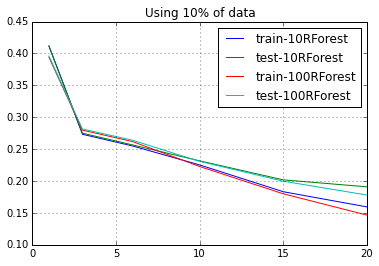

In [38]:
keys,train,test = extract_errors(RF10p_10)
st='10RForest'
plot(keys,train,label='train-'+st)
plot(keys,test,label='test-'+st)
keys,train,test = extract_errors(RF10p_100)
st='100RForest'
plot(keys,train,label='train-'+st)
plot(keys,test,label='test-'+st)
title('Using 10% of data')
grid()
legend()

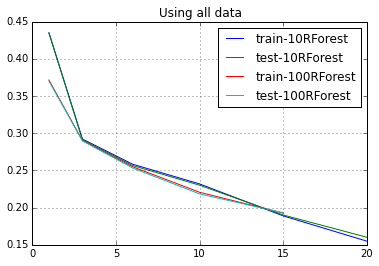

In [39]:
keys,train,test = extract_errors(RFall_10)
st='10RForest'
plot(keys,train,label='train-'+st)
plot(keys,test,label='test-'+st)
keys,train,test = extract_errors(RFall_100)
st='100RForest'
plot(keys,train,label='train-'+st)
plot(keys,test,label='test-'+st)
title('Using all data')
grid()
legend()